<a href="https://colab.research.google.com/github/Gustavo-br-rj/PROJ-BI_MASTER/blob/main/1_AVAL_RN_TEMP_C_4451_08001A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Previsão de Série Temporal da Temperatura de Mancais Utilizando LSTM


## Parte 0 - Importação das Bibliotecas

In [42]:
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#tf.__version__

## Parte 1 - Importação do Dataset e Estatística Descritiva

In [43]:
# Importação da Base de Dados
dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/DATASETS/dataset_C-4451_08001A.csv')

In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EQUIPAMENTO  2244 non-null   object 
 1   MANCAL       2244 non-null   object 
 2   DATA         2244 non-null   object 
 3   TEMPERATURA  2244 non-null   float64
dtypes: float64(1), object(3)
memory usage: 70.2+ KB


In [45]:
dataset.head()

,EQUIPAMENTO,MANCAL,DATA,TEMPERATURA
0,C-4451.08001A,EJA1.A-TC21.F_CV,04/01/2021,69.88962
1,C-4451.08001A,EJA1.A-TC21.F_CV,05/01/2021,69.59235
2,C-4451.08001A,EJA1.A-TC21.F_CV,06/01/2021,69.56962
3,C-4451.08001A,EJA1.A-TC21.F_CV,07/01/2021,67.57046
4,C-4451.08001A,EJA1.A-TC21.F_CV,15/01/2021,69.05307


In [46]:
#Conversão do campo data para datetime e ordenação do dataset
dataset['DATA'] = pd.to_datetime(dataset['DATA'],dayfirst=True)
dataset = dataset.sort_values(['EQUIPAMENTO', 'MANCAL', 'DATA'], ascending=[1, 1, 1])

In [47]:
dataset.groupby(['EQUIPAMENTO','MANCAL']).count()

DATA  TEMPERATURA
EQUIPAMENTO   MANCAL                                
C-4451.08001A EJA1.A-TC21.F_CV      132          132
              EJA1.A-TC22.F_CV      132          132
              EJA1.A-TC23.F_CV      132          132
              EJA1.A-TC25.F_CV      132          132
              EJA1.A-TC250.F_CV     132          132
              EJA1.A-TC251.F_CV     132          132
              EJA1.A-TC26.F_CV      132          132
              EJA1.A-TC27.F_CV      132          132
              EJA1.A-TC28.F_CV      132          132
              EJA1.A-TE1200A.F_CV   132          132
              EJA1.A-TE1200B.F_CV   132          132
              EJA1.A-TE1203A.F_CV   132          132
              EJA1.A-TE1203B.F_CV   132          132
              EJA1.A-TE1206A.F_CV   132          132
              EJA1.A-TE1206B.F_CV   132          132
              EJA1.A-TE1209A.F_CV   132          132
              EJA1.A-TE1209B.F_CV   132          132

In [48]:
dataset.describe()

,TEMPERATURA
count,2244.000000
mean,64.119683
std,14.794079
min,18.718320
25%,54.898420
50%,59.503090
75%,71.550998
max,196.001790


In [49]:
#Separação do dataset por mancais
mancais = dataset['MANCAL'].unique().tolist()

manc1 = dataset.loc[(dataset["MANCAL"] == mancais[0]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc2 = dataset.loc[(dataset["MANCAL"] == mancais[1]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc3 = dataset.loc[(dataset['MANCAL'] == mancais[2]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc4 = dataset.loc[(dataset['MANCAL'] == mancais[3]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc5 = dataset.loc[(dataset["MANCAL"] == mancais[4]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc6 = dataset.loc[(dataset['MANCAL'] == mancais[5]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc7 = dataset.loc[(dataset['MANCAL'] == mancais[6]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc8 = dataset.loc[(dataset['MANCAL'] == mancais[7]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc9 = dataset.loc[(dataset['MANCAL'] == mancais[8]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc10 = dataset.loc[(dataset['MANCAL'] == mancais[9]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc11 = dataset.loc[(dataset['MANCAL'] == mancais[10]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc12 = dataset.loc[(dataset['MANCAL'] == mancais[11]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc13 = dataset.loc[(dataset['MANCAL'] == mancais[12]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc14 = dataset.loc[(dataset['MANCAL'] == mancais[13]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc15 = dataset.loc[(dataset['MANCAL'] == mancais[14]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc16 = dataset.loc[(dataset['MANCAL'] == mancais[15]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
manc17 = dataset.loc[(dataset['MANCAL'] == mancais[16]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]

manc1 = manc1.reset_index(drop=True)
manc2 = manc2.reset_index(drop=True)
manc3 = manc3.reset_index(drop=True)
manc4 = manc4.reset_index(drop=True)
manc5 = manc5.reset_index(drop=True)
manc6 = manc6.reset_index(drop=True)
manc7 = manc7.reset_index(drop=True)
manc8 = manc8.reset_index(drop=True)
manc9 = manc9.reset_index(drop=True)
manc10 = manc10.reset_index(drop=True)
manc11 = manc11.reset_index(drop=True)
manc12 = manc12.reset_index(drop=True)
manc13 = manc13.reset_index(drop=True)
manc14 = manc14.reset_index(drop=True)
manc15 = manc15.reset_index(drop=True)
manc16 = manc16.reset_index(drop=True)
manc17 = manc17.reset_index(drop=True)

#### Análise Gráfica

No handles with labels found to put in legend.


Text(0.5, 0, 'Temperatura')

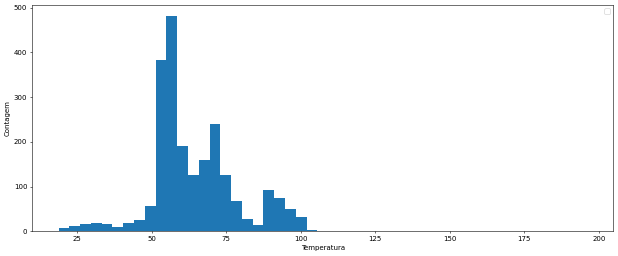

In [50]:
temperaturas = dataset.to_numpy()
temperaturas = temperaturas[:,3:4]
bins = np.linspace(temperaturas.min(), temperaturas.max(), 50)
plt.figure(figsize=(15, 6), dpi=50)
plt.hist(temperaturas, bins=bins)
plt.legend()
plt.ylabel('Contagem')
plt.xlabel('Temperatura')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


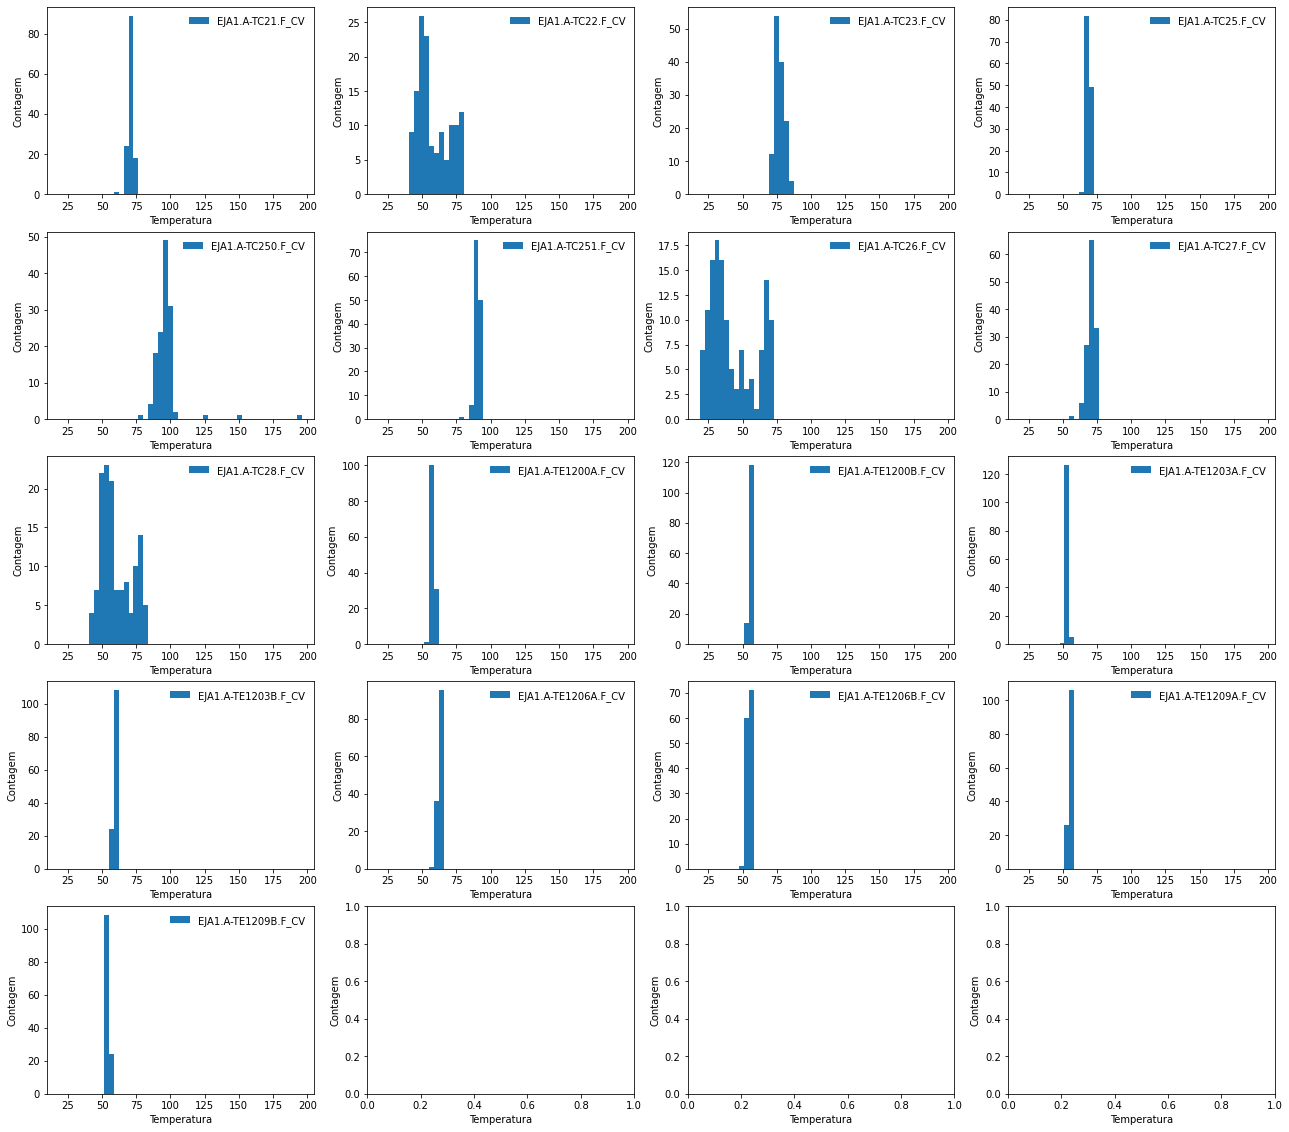

In [53]:
tempsManc1 = manc1.to_numpy()[:,3:4]
tempsManc2 = manc2.to_numpy()[:,3:4]
tempsManc3 = manc3.to_numpy()[:,3:4]
tempsManc4 = manc4.to_numpy()[:,3:4]
tempsManc5 = manc5.to_numpy()[:,3:4]
tempsManc6 = manc6.to_numpy()[:,3:4]
tempsManc7 = manc7.to_numpy()[:,3:4]
tempsManc8 = manc8.to_numpy()[:,3:4]
tempsManc9 = manc9.to_numpy()[:,3:4]
tempsManc10 = manc10.to_numpy()[:,3:4]
tempsManc11 = manc11.to_numpy()[:,3:4]
tempsManc12 = manc12.to_numpy()[:,3:4]
tempsManc13 = manc13.to_numpy()[:,3:4]
tempsManc14 = manc14.to_numpy()[:,3:4]
tempsManc15 = manc15.to_numpy()[:,3:4]
tempsManc16 = manc16.to_numpy()[:,3:4]
tempsManc17 = manc17.to_numpy()[:,3:4]

ncols = 4
nrows = 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 20))

#plt.figure(figsize=(30, 30), dpi=50)
axes[0][0].hist(tempsManc1, bins=bins, label=mancais[0])
axes[0][1].hist(tempsManc2, bins=bins, label=mancais[1])
axes[0][2].hist(tempsManc3, bins=bins, label=mancais[2])
axes[0][3].hist(tempsManc4, bins=bins, label=mancais[3])

axes[1][0].hist(tempsManc5, bins=bins, label=mancais[4])
axes[1][1].hist(tempsManc6, bins=bins, label=mancais[5])
axes[1][2].hist(tempsManc7, bins=bins, label=mancais[6])
axes[1][3].hist(tempsManc8, bins=bins, label=mancais[7])

axes[2][0].hist(tempsManc9, bins=bins, label=mancais[8])
axes[2][1].hist(tempsManc10, bins=bins, label=mancais[9])
axes[2][2].hist(tempsManc11, bins=bins, label=mancais[10])
axes[2][3].hist(tempsManc12, bins=bins, label=mancais[11])

axes[3][0].hist(tempsManc13, bins=bins, label=mancais[12])
axes[3][1].hist(tempsManc14, bins=bins, label=mancais[13])
axes[3][2].hist(tempsManc15, bins=bins, label=mancais[14])
axes[3][3].hist(tempsManc16, bins=bins, label=mancais[15])

axes[4][0].hist(tempsManc17, bins=bins, label=mancais[16])

for i in range(nrows):
    for j in range(ncols):
      axes[i][j].set_ylabel('Contagem')
      axes[i][j].set_xlabel('Temperatura')
      leg = axes[i][j].legend(loc='upper right')
      leg.draw_frame(False)
      
plt.show()

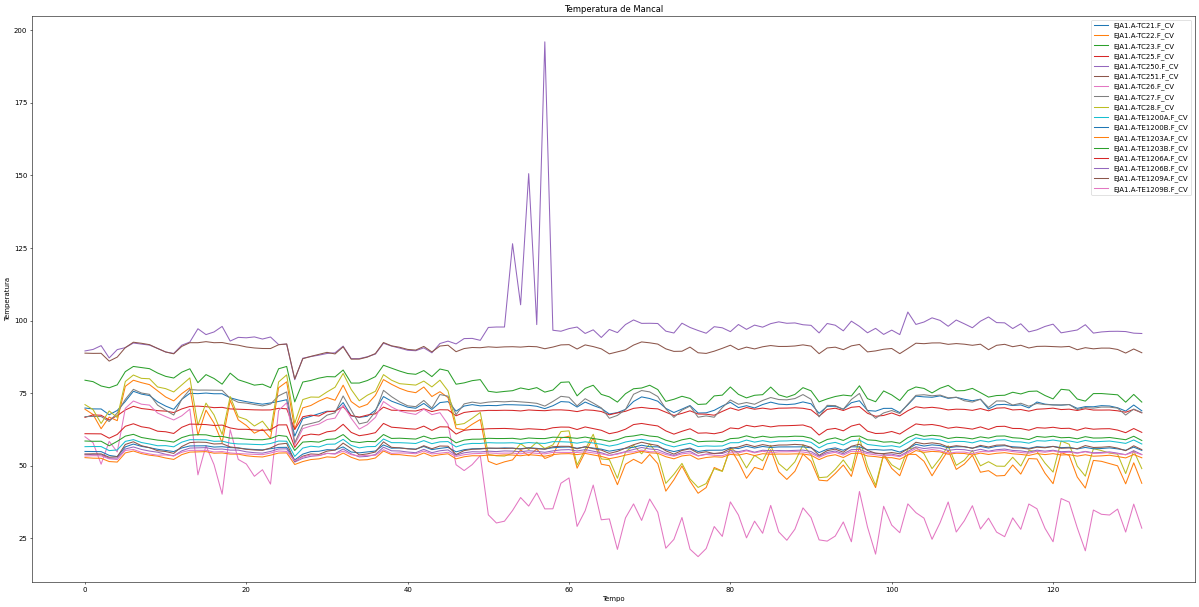

In [54]:
plt.figure(figsize=(30, 15), dpi=50)

plt.plot(tempsManc1,  label=mancais[0])
plt.plot(tempsManc2,  label=mancais[1])
plt.plot(tempsManc3,  label=mancais[2])
plt.plot(tempsManc4,  label=mancais[3])
plt.plot(tempsManc5,  label=mancais[4])
plt.plot(tempsManc6,  label=mancais[5])
plt.plot(tempsManc7,  label=mancais[6])
plt.plot(tempsManc8,  label=mancais[7])
plt.plot(tempsManc9,  label=mancais[8])
plt.plot(tempsManc10, label=mancais[9])
plt.plot(tempsManc11, label=mancais[10])
plt.plot(tempsManc12, label=mancais[11])
plt.plot(tempsManc13, label=mancais[12])
plt.plot(tempsManc14, label=mancais[13])
plt.plot(tempsManc15, label=mancais[14])
plt.plot(tempsManc16, label=mancais[15])
plt.plot(tempsManc17, label=mancais[16])

plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.legend()
plt.show()

## Parte 2 - Preprocessamento de Dados

### Separação do conjunto de Treino e Teste

In [55]:
datasetMancal = manc1
#Conversão das temperaturas para número inteiro. Teste para ver se ajuda a RN. 
#datasetMancal = datasetMancal.astype({"TEMPERATURA": int})
#datasetMancal['TEMPERATURA'] = datasetMancal['TEMPERATURA'].round(decimals=1)

#Calculando tamanho dos conjuntos de treino e teste
train_size = math.ceil(len(datasetMancal)*0.85)
test_size  = len(datasetMancal) - train_size

#Separando conjuto de treino e teste apenas com valor da série
train_set = datasetMancal.iloc[0:train_size, 3:4].values
test_set  = datasetMancal.iloc[train_size:(train_size + test_size), 3:4].values

### Normalização

In [56]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

### Criar a estrutura de dados com janela WINDOW e output OUTPUTSIZE para entrada na RN

In [57]:
def prepareSetRN(windowSize, outputSize, flatSet ):
  preparedX = []
  preparedY = []
  setSize = len(flatSet)
  for i in range(windowSize, setSize - (outputSize-1)):
    preparedX.append(flatSet[i-windowSize:i, 0])
    preparedY.append(flatSet[i:i + outputSize, 0])

  preparedX, preparedY = np.array(preparedX), np.array(preparedY)
  return preparedX, preparedY

## Parte 3 - Construção da RNN

### Parâmetros selecionados para geração da rede

In [58]:
window   = 3
output   = 3
layer    = 3
unit     = [150,80,80]
dropout  = 0.2 
optmizer = 'Adam'
epochs      = 800
batch_size  = 32

### Construção da Rede completa

In [59]:
def criaRN(outputParam, layerParam, unitParam, dropoutParam, optmizerParam, X_trainParam):
  # Inicializar a RNN
  regressor = Sequential()

  # Adicionar a primeira camada LSTM e Dropout 
  regressor.add(LSTM(units = unitParam[0], return_sequences = (layerParam > 1), input_shape = (X_trainParam.shape[1], 1)))
  regressor.add(Dropout(dropoutParam))
 
  if ( layerParam >= 2 ):
    # Adicionar a segunda camada LSTM e Dropout
    regressor.add(LSTM(units = unitParam[1], return_sequences = (layerParam > 2)))
    regressor.add(Dropout(dropoutParam))

  if ( layerParam >= 3):
    # Adicionar a terceira camada LSTM e Dropout
    regressor.add(LSTM(units = unitParam[2], return_sequences = (layerParam > 3)))
    regressor.add(Dropout(dropoutParam))

  # camada de saída
  regressor.add(Dense(units = outputParam, activation='linear'))
  #Testar sigmoid e linear

  # Compilar a rede
  regressor.compile(optimizer = optmizerParam, loss = 'mean_squared_error', metrics=['accuracy'])

  # Visualizar a rede
  #regressor.summary()

  return regressor


In [60]:
def backToFlat( windowSet ):
    flatSet     = []
    window_size = windowSet.shape[1]
    setSize     = len(windowSet)

    #Adiciona as primeiras colunas do primeiro registro quando a janela > 1
    if window_size > 1:
      for i in range(0, window_size-1):
        flatSet.append(windowSet[0, i])

    for i in range(0, setSize):
        flatSet.append(windowSet[i, window_size-1])

    flatSet = np.array(flatSet)

    return np.reshape(flatSet, (flatSet.shape[0], 1)) 

###Treinamento da RN

In [61]:
X_train = []
y_train = []
X_train, y_train = prepareSetRN(window, output, training_set_scaled)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

regressor = criaRN(output, layer, unit, dropout, optmizer, X_train)
history = regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
            
#Acréscimo da janela no conjunto de teste para pegar os últimos registros do treino
test_set_first_window  = dataset.iloc[train_size - window:(train_size + test_size), 3:4].values

test_set_scaled = sc.transform(test_set_first_window)

X_test = []
y_test = []

X_test, y_test = prepareSetRN(window, output, test_set_scaled)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

test_predicted = backToFlat(predicted)

rmse = math.sqrt(mean_squared_error(test_set, test_predicted))
mse  = mean_squared_error(test_set, test_predicted)
mape = np.mean(np.abs((test_set - test_predicted) / test_set)) * 100              

Epoch 1/800
4/4 [==============================] - 7s 9ms/step - loss: 0.4851 - accuracy: 0.3426
Epoch 2/800
4/4 [==============================] - 0s 6ms/step - loss: 0.4224 - accuracy: 0.3056
Epoch 3/800
4/4 [==============================] - 0s 6ms/step - loss: 0.3219 - accuracy: 0.2963
Epoch 4/800
4/4 [==============================] - 0s 6ms/step - loss: 0.1804 - accuracy: 0.3148
Epoch 5/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0466 - accuracy: 0.4259
Epoch 6/800
4/4 [==============================] - 0s 6ms/step - loss: 0.0854 - accuracy: 0.3611
Epoch 7/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0378 - accuracy: 0.3148
Epoch 8/800
4/4 [==============================] - 0s 10ms/step - loss: 0.0352 - accuracy: 0.2222
Epoch 9/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0455 - accuracy: 0.2778
Epoch 10/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0348 - accuracy: 0.2685
Epoch 11/800
4/4 [==========

### Análise do Treinamento

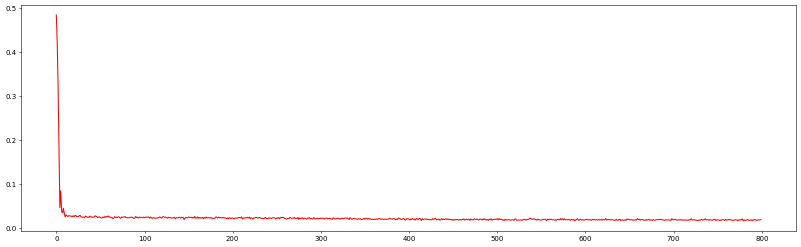

In [62]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['loss'], color = 'red', label = 'Loss')

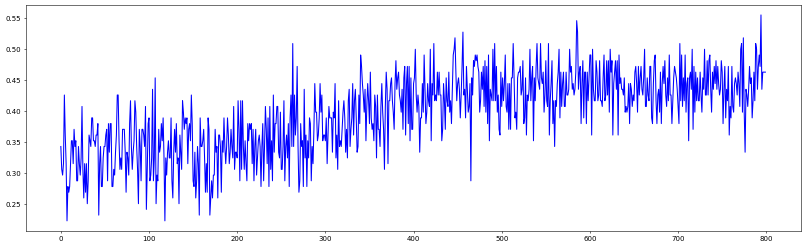

In [63]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['accuracy'], color = 'blue', label = 'Accuracy')

## Parte 4 - Fazer as previsões e analisar os resultados

###Construir estrutura para teste

In [64]:
#Acréscimo da janela no conjunto de teste para pegar os últimos registros do treino
test_set_first_window  = dataset.iloc[train_size - window:(train_size + test_size), 3:4].values

test_set_scaled = sc.transform(test_set_first_window)

X_test = []
y_test = []

X_test, y_test = prepareSetRN(window, output, test_set_scaled)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer previsões

In [65]:
predicted = regressor.predict(X_train)
predicted = sc.inverse_transform(predicted)

training_predicted = backToFlat(predicted)

predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

test_predicted = backToFlat(predicted)

### Visualizar os resultados de treino e teste

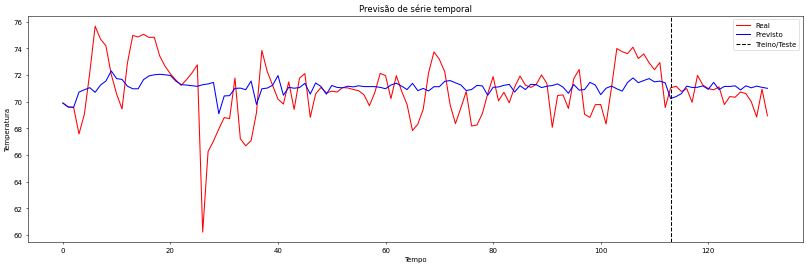

In [72]:
#allTargetData = np.vstack((test_set))
#allForecastedData = np.vstack((test_predicted))
allTargetData = np.vstack((train_set, test_set))
allForecastedData = np.vstack((train_set[0:window], training_predicted, test_predicted))

plt.figure(figsize=(20, 6), dpi=50)
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.axvline(x=len(train_set), label='Treino/Teste', c='k',ls='--')

plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

In [67]:
for i in range(0, 20):
  print( allTargetData[i], allForecastedData[i])

[69.88962] [69.88962]
[69.59235] [69.59235]
[69.56962] [69.56962]
[67.57046] [70.71259308]
[69.05307] [70.88735199]
[72.16129] [71.04408264]
[75.65772] [70.69487]
[74.68783] [71.23640442]
[74.18875] [71.53992462]
[72.03129] [72.29532623]
[70.5655] [71.72150421]
[69.44159] [71.6622467]
[72.88263] [71.1559906]
[74.95892] [70.95785522]
[74.84634] [70.96005249]
[75.04561] [71.64971161]
[74.81426] [71.92215729]
[74.82045] [72.00930023]
[73.42778] [72.04506683]
[72.65412] [72.01233673]


## Parte 5 - Métricas de avaliação

In [68]:
rmse = math.sqrt(mean_squared_error(test_set, test_predicted))
print('RMSE: ', rmse)

RMSE:  0.971820647925619


In [69]:
mse = mean_squared_error(test_set, test_predicted)
print('MSE: ',mse)

MSE:  0.9444353717345698


In [70]:
mape = np.mean(np.abs((test_set - test_predicted) / test_set)) * 100
print('MAPE: ',mape, '%')

MAPE:  1.0589946038225884 %


## Parte 6 - Salvando e recarregando o modelo

In [73]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
diretorio = '/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/MODELOS/'
nomeModelo = '{0}{1}__{2}_TESTE_model'.format(diretorio,datasetMancal['EQUIPAMENTO'].to_numpy()[0], datasetMancal['MANCAL'].to_numpy()[0])
regressor.save(nomeModelo)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/MODELOS/C-4451.08001A__EJA1.A-TC21.F_CV_TESTE_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/MODELOS/C-4451.08001A__EJA1.A-TC21.F_CV_TESTE_model/assets


In [74]:
# It can be used to reconstruct the model identically.
reconstructed_model = load_model(nomeModelo)

In [85]:
# Let's check:
teste = np.testing.assert_allclose(
    regressor.predict(X_test), reconstructed_model.predict(X_test)
)